# Tutorial 10 - Neural Networks (NN): 


### Motivation for Neural Networks

**How to learn non-linear separators (or regressors)?**

**Idea 1**:  Transform to space where it's linearly separable

1. Manual *feature engineering* : add x1**2, x1*x2, log(1+x1), XOR(x1, x2)
1. Automate with basis functions (e.g. polynomial regression)
1. Automate with kernel trick and non-linear Support Vector Machines

**Idea 2**:  Combine classifiers (Ensembles)

1. Linearly combine trees (bagging --> RandomForest, boosting --> XGBoost)
1. Linearly combine score functions? 
    1. Linear score functions - NAY.  done nothing! (why?)
    1. Combine "activated" (e.g. logit) score functions --> YEAH! a hidden layer!

Generalized Linear Model (e.g. LR) == 1-layer ("shallow") Neural Network.

Combination of GLM outputs (e.g. LR2 on LR1 scores) --> 2-layer Neural Network

**Idea 3**:  Learnt score functions as new features (Deep Learning)
1. Apply recursively the idea of hidden layer
2. Learn end-to-end using Backpropagation


## Perceptron & Multi-Layered Perceptron (MLP)

<div dir=rtl>
    בתרגול זה נכיר מודל אחד של רשת נוירונים - מודל פרספטרון רב שכבתי. נראה תחילה דוגמה לרשת כזו המכילה אינפוט בגודל 4, שכבה חבויה אחת עם חמישה נוירונים ושכבת אאוטפוט עם נוירון אחד:
</div>

![](https://www.kdnuggets.com/wp-content/uploads/strika-1-fig_neural_network_1.png)

<div dir=rtl>
    לפני שנבין מה הרשת עושה, נתמקד תחילה באבן היסוד שלה - הפרספטרון:
</div>

![](https://www.allaboutcircuits.com/uploads/articles/how-to-train-a-basic-perceptron-neural-network_rk_aac_image1.jpg)

<div dir=rtl>
    הפרספטרון הוא למעשה פונקציה המכילה פרמטרים. בהינתן אינפוט, הפרספטרון כופל את הפרמטרים באינפוטים, סוכם, מחיל פונקציה כלשהי על התוצאה ופולט מספר אחד ויחיד בתור פלט:
</div>

\begin{align}
Z = w_0 + a_1 \cdot w_1 + a_2 \cdot w_2 = W \cdot A\\
output_0 = f(Z)\\
f(x) = \sigma (x) \\ \\
Z > 0 \rightarrow output_0 > 0.5 \\ 
Z < 0 \rightarrow output_0 < 0.5
\end{align}

<div dir=rtl>
    כאשר מחילים פונקציה מסוג סיגמואיד (כמו שמוצג באיור) הנוירון יצביע על הסתברות גדולה מחצי אם תוצאת הסכימה גדולה מ0, ועל הסתברות קטנה מחצי אם תוצאת הסכימה קטנה מאפס.
    <br />
    נראה מוכר? זה בדיוק המשוואות של רגרסיה לוגיסטית.
</div>



## <div dir=rtl> שאלה 1</div>
<div dir=rtl>
  הדגימי לימוד משטח הפרדה לא ליניארי בעזרת רשת נוירונים מינימאליסטית, 

  בדומה ל - https://playground.tensorflow.org/
  
  (מומלץ בחום! תנסו לשחק עם זה, להפריד את השבלול ולבדוק השפעה של רגולריזצייה)
</div>

מחברת מפורטת בה נעזרנו -  מומלצת להעמקה עצמאית   - עוברת על הכל בצעדים קטנים: 

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb

אנחנו נעשה טיפה יותר דחוס בהתאם לאילוצים

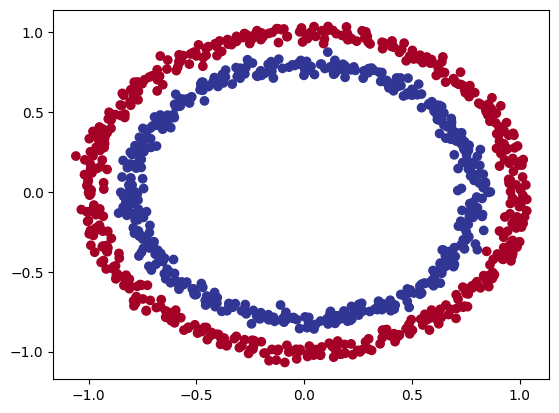

In [25]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from sklearn.datasets import make_circles

X, y = make_circles(1000,            # total data points
                    noise=0.03,      # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [26]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn

# Technicality of torch: transforming into its preferred datatype ("Tensor")
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

In [27]:
# Create a model and a loss function

def create_model_and_loss(layers, sigmoid_in_model = False):
    """ handling the toch nuance in one place to ensure consistency
        (out effort to support of the two equivalent formulations completely optional, 
         in practice just choose and run with one)
    """
    # BCELoss: no sigmoid built-in (expects [0, 1] output of network ending with sigmoid)
    # BCEWithLogitsLoss: sigmoid built-in (expects logit from network w.o. sigmoid)
    if sigmoid_in_model:
        layers.append(nn.Sigmoid())
        loss_fn = nn.BCELoss() 
    else:
        loss_fn = nn.BCEWithLogitsLoss()

    return nn.Sequential(*layers), loss_fn

layers = [
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
]

model_0, loss_fn = create_model_and_loss(layers)

In [28]:

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

def train(model, loss_fn, lr=0.1, epochs=1000, sigmoid_in_model=False):
    """ Simple training and evaluation loop for a BINARY classifier
        NOTE: batch size equals training set size aka one step per epoch

        Args:
        lr:  learning rate
        epochs:  numer of times we "pass" over the data
    """
    
    # Create an optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        ### Training
        model.train()  # set in train mode

        # 1. Forward pass 
        if sigmoid_in_model:
            model_out = probs = model(X_train).squeeze() 
            # squeeze to remove extra `1` dimensions,
        else:
            model_out = y_logits = model(X_train).squeeze()
            probs = torch.sigmoid(y_logits)
        # NOTE round turns the probability into "hard" prediction (th=.5)
        y_pred = torch.round(probs) 
    
        # 2. Calculate loss/accuracy        
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred) 

        loss = loss_fn(model_out, y_train) 
        optimizer.zero_grad()

        # 3. Backpropagation! 
        loss.backward()

        # 4. Apply gradient step to weights!
        optimizer.step()

        ### Testing
        model.eval()  # set in evaluation mode mode
        with torch.inference_mode():
            # 1. Forward pass
            if sigmoid_in_model:
                model_out = probs = model(X_test).squeeze() 
            else:
                model_out = y_logits = model(X_test).squeeze()
                probs = torch.sigmoid(y_logits)
            # NOTE round turns the probability into "hard" prediction (th=.5)
            test_pred = torch.round(probs) 

            # 2. Caculate loss/accuracy
            test_loss = loss_fn(model_out, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Print out what's happening every 10 epochs
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

    return model

model = train(model_0, loss_fn)

Epoch: 0 | Loss: 0.72174, Accuracy: 50.00% | Test loss: 0.71875, Test acc: 50.00%
Epoch: 100 | Loss: 0.69345, Accuracy: 50.25% | Test loss: 0.69514, Test acc: 51.50%
Epoch: 200 | Loss: 0.69310, Accuracy: 50.62% | Test loss: 0.69511, Test acc: 47.00%
Epoch: 300 | Loss: 0.69301, Accuracy: 50.75% | Test loss: 0.69491, Test acc: 46.50%
Epoch: 400 | Loss: 0.69299, Accuracy: 51.00% | Test loss: 0.69480, Test acc: 47.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69474, Test acc: 46.50%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69471, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69470, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69469, Test acc: 44.50%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69468, Test acc: 45.00%


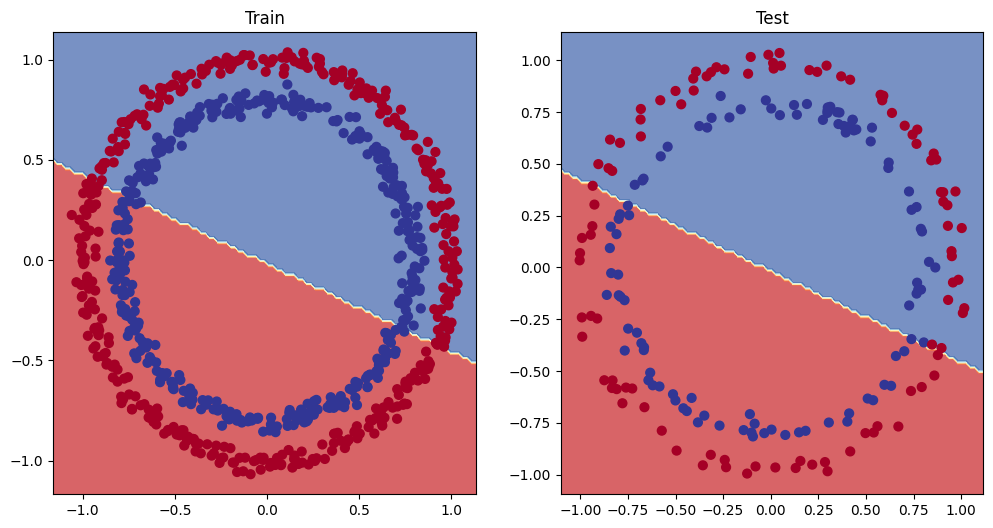

In [29]:
from helper_functions import plot_predictions, plot_decision_boundary

def visualize(model):
    """ Plot decision boundaries for training and test sets """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, X_test, y_test)

visualize(model)

Epoch: 0 | Loss: 0.69850, Accuracy: 52.00% | Test loss: 0.69575, Test acc: 52.00%
Epoch: 100 | Loss: 0.69149, Accuracy: 50.12% | Test loss: 0.69021, Test acc: 51.00%
Epoch: 200 | Loss: 0.68836, Accuracy: 51.00% | Test loss: 0.68752, Test acc: 54.00%
Epoch: 300 | Loss: 0.68512, Accuracy: 51.50% | Test loss: 0.68467, Test acc: 54.50%
Epoch: 400 | Loss: 0.68151, Accuracy: 52.62% | Test loss: 0.68143, Test acc: 55.00%
Epoch: 500 | Loss: 0.67727, Accuracy: 54.12% | Test loss: 0.67765, Test acc: 55.50%
Epoch: 600 | Loss: 0.67221, Accuracy: 58.13% | Test loss: 0.67328, Test acc: 59.50%
Epoch: 700 | Loss: 0.66588, Accuracy: 61.75% | Test loss: 0.66781, Test acc: 63.00%
Epoch: 800 | Loss: 0.65794, Accuracy: 72.38% | Test loss: 0.66109, Test acc: 71.00%
Epoch: 900 | Loss: 0.64768, Accuracy: 80.38% | Test loss: 0.65330, Test acc: 77.50%
Epoch: 1000 | Loss: 0.63484, Accuracy: 88.50% | Test loss: 0.64463, Test acc: 83.50%
Epoch: 1100 | Loss: 0.61987, Accuracy: 87.12% | Test loss: 0.63416, Test acc:

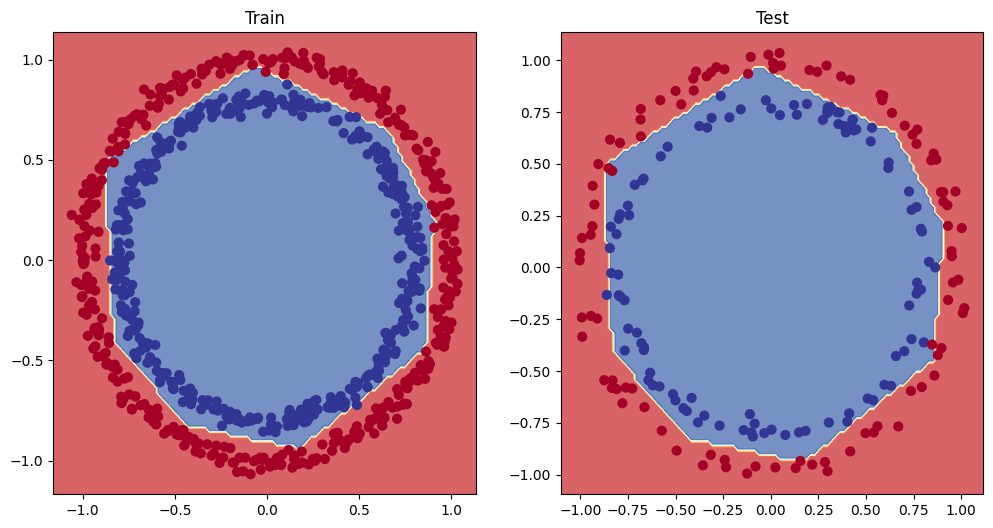

In [30]:
hidden_layer_width = 7 
 
# TODO try more neurons and/or more layers

layers = [
    nn.Linear(in_features=2, out_features=hidden_layer_width),
    nn.ReLU(), # !! # TODO try more hidden
    # nn.Linear(in_features=hidden_layer_width, out_features=hidden_layer_width),
    # nn.ReLU(),
    nn.Linear(in_features=hidden_layer_width, out_features=1)
]

model_1, loss_fn = create_model_and_loss(layers)

model = train(model_1, loss_fn, lr=0.1, epochs=3000)
visualize(model)

<div dir=rtl>מודל פרספטרון רב שכבתי.
 
 ריבוב לסירוגין של (א) שכבה לינארית - כפל מטריצה והוספת ביאס, ו (ב) שכבת אקטיבציה נקודתית:  
</div>

\begin{align}
Z = W \cdot x + b \\
y = f(Z)
\end{align}


---


## <div dir=rtl> שאלה 2</div>


<div dir=rtl>
הדגמה של לימוד סיווג רב-מחלקות בעזרת רשת נוירונים
multi-class classification
</div>

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


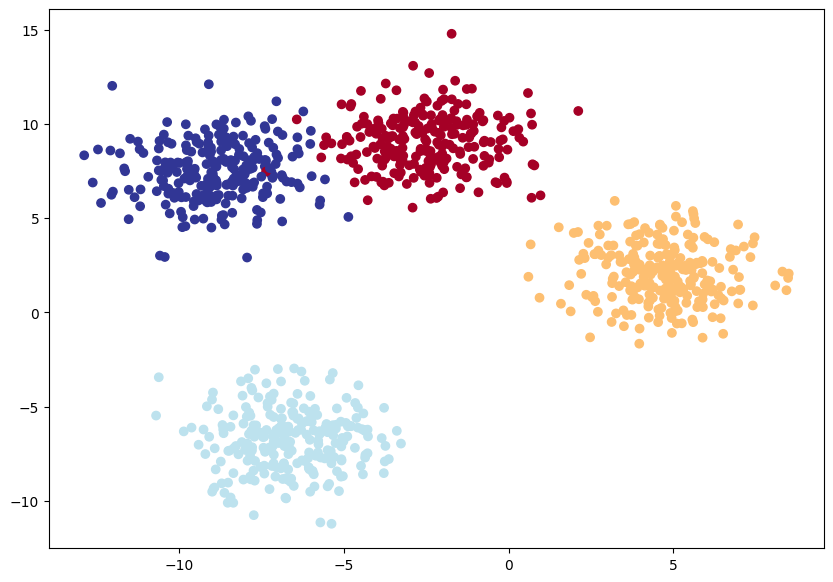

In [8]:
from sklearn.datasets import make_blobs

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = \
train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [9]:

def train(model, 
          X_train, y_train, X_test, y_test,
          loss_fn=nn.CrossEntropyLoss(), lr=0.1, epochs=1000):
    """ Simple training and evaluation loop for a MULTICLASS classifier
        NOTE: batch size equals training set size aka one step per epoch

        Args:
        lr:  learning rate
        epochs:  numer of times we "pass" over the data
    """
    
    # Create an optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        ### Training ###
        model.train()  # set in train mode

        # 1. Forward pass 
        model_out = train_logits = model(X_train).squeeze()
        # probs = torch.sigmoid(train_logits)    # binary
        # train_pred = torch.round(train_logits) # binary
        """ BINARY --> MULTICLASS:  
        (A) sigmoid --> softmax 
        (B) round(p(1)) --> argmax(p=[p0,p1,p2,..])  ({0,1} --> indices)
        """
        train_probs = torch.softmax(train_logits, dim=1)
        y_train_pred = train_probs.argmax(dim=1)
        
        # 2. Calculate loss/accuracy        
        acc = accuracy_fn(y_true=y_train, y_pred=y_train_pred) 

        loss = loss_fn(model_out, y_train) 
        optimizer.zero_grad()

        # 3. Backpropagation! 
        loss.backward()

        # 4. Apply gradient step to weights!
        optimizer.step()

        ### Testing
        model.eval()  # set in evaluation mode mode
        with torch.inference_mode():
            # 1. Forward pass
            model_out = test_logits = model(X_test).squeeze()
            
            # probs = torch.sigmoid(y_logits) # binary            
            # test_pred = torch.round(probs)  # binary
            """ BINARY --> MULTICLASS:  
            (A) sigmoid --> softmax 
            (B) round(p(1)) --> argmax(p=[p0,p1,p2,..])  ({0,1} --> indices)
            """
            test_probs = torch.softmax(test_logits, dim=1)
            # TODO can we skip the softmax here? 
            test_pred = test_probs.argmax(dim=1)

            # 2. Caculate loss/accuracy
            test_loss = loss_fn(model_out, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Print out what's happening every 10 epochs
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

    return model

model_mc = nn.Sequential(nn.Linear(in_features=NUM_FEATURES, out_features=hidden_layer_width),
                         nn.ReLU(),
                         nn.Linear(in_features=hidden_layer_width, out_features=hidden_layer_width),
                         nn.ReLU(),
                         nn.Linear(in_features=hidden_layer_width, out_features=NUM_CLASSES))
# TODO do we need sigmoid or softmax?
# TODO can we reduce number of layers? maybe WITHOUT hidden layers?

model = train(model_mc, X_blob_train, y_blob_train, X_blob_test, y_blob_test)

Epoch: 0 | Loss: 1.25531, Accuracy: 31.50% | Test loss: 0.92151, Test acc: 45.00%
Epoch: 100 | Loss: 0.27110, Accuracy: 99.12% | Test loss: 0.23082, Test acc: 99.00%
Epoch: 200 | Loss: 0.12103, Accuracy: 99.25% | Test loss: 0.09583, Test acc: 99.50%
Epoch: 300 | Loss: 0.07749, Accuracy: 99.38% | Test loss: 0.05829, Test acc: 99.50%
Epoch: 400 | Loss: 0.05909, Accuracy: 99.38% | Test loss: 0.04243, Test acc: 99.50%
Epoch: 500 | Loss: 0.04934, Accuracy: 99.38% | Test loss: 0.03403, Test acc: 99.50%
Epoch: 600 | Loss: 0.04327, Accuracy: 99.38% | Test loss: 0.02892, Test acc: 99.50%
Epoch: 700 | Loss: 0.03252, Accuracy: 99.38% | Test loss: 0.02002, Test acc: 99.50%
Epoch: 800 | Loss: 0.02648, Accuracy: 99.38% | Test loss: 0.01487, Test acc: 99.50%
Epoch: 900 | Loss: 0.02438, Accuracy: 99.50% | Test loss: 0.01304, Test acc: 99.50%


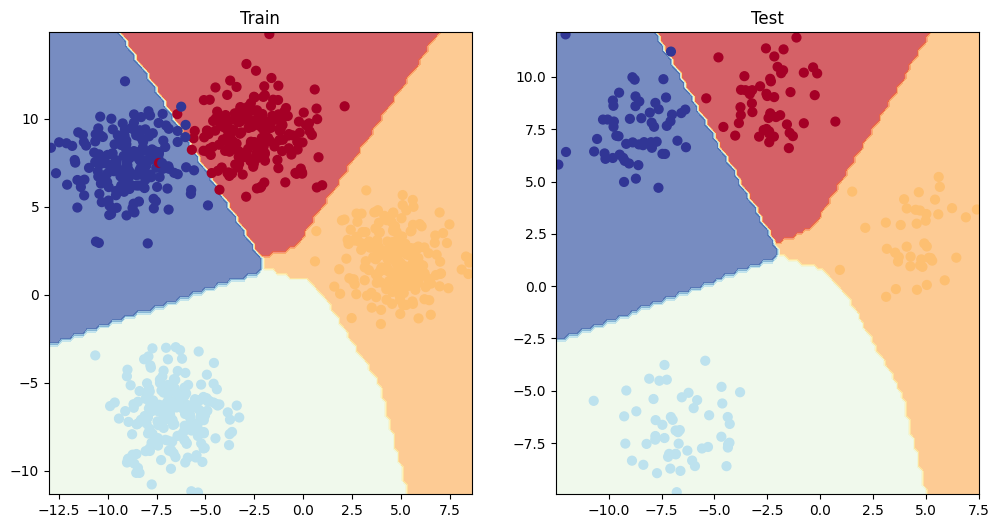

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_mc, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_mc, X_blob_test, y_blob_test)

# Generalization and Regularization

Neural Networks have huge number of parameters (e.g. 1e4 for MLP w two 100-neuron hidden layers, 1e6-1e8 for Computer Vision, 1e9-1e12 for LLMs s.a. ChatGPT), often more than examples - even for big datasets! How come they don't overfit (e.g. simply memorize train set) or stuck at bad local minima? 
Several answers: 
* Huge datasets and weight-sharing tricks to improve examples/params ratio
* Magic of high dimensions 
* Use of regularization techniques such as:
    * Per-batch in-line normalization
    * Dropout 
    * Weight-Decay aka L2 regularization. 
    
Wait a minute, what L2? 

But what if I told you that any model of scikit-learn uses the L2 normalization by default?

Adding ||w||^2 to loss, aka adding -a*w  term to gradient, hence reducing w magnitude (hence "weight decay"). 

But we know it's all about W's DIRECTION, right? So what's going on?

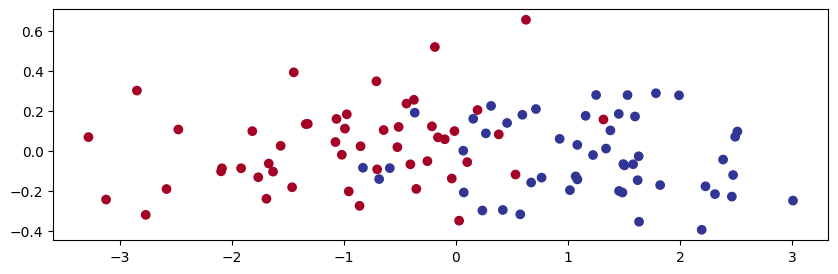

In [21]:

import numpy as np, matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

N = 100
X_blob, y_blob = make_blobs(n_samples=N,
    n_features=2,
    centers=[[-1, 0], [1, 0]],
    cluster_std=1
)
plt.figure(figsize=(10,3))
X_blob[:, 1] /= 5
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [12]:
from sklearn.metrics import log_loss

def get_loss(w, X_blob, y_blob):
    w = np.array([w]).T
    logit = X_blob @ w
    y_pred_proba = 1 / (1 + np.exp(-logit))
    return log_loss(y_blob, y_pred_proba) 
    
get_loss([1, 0], X_blob, y_blob)

0.3729096977922483

Let's investigate how the LOSS LANDSCAPE looks like for this toy problem (two features, logistic loss),

With / without REGULARIZATION (L2: adding w**2 term to loss, aka weight decay)

On the way we'll also check if sklearn's LogisticRegress does what it says and finds the minimum.

We'll repeat over a few REALIZATIONS of the training set from same distribution.

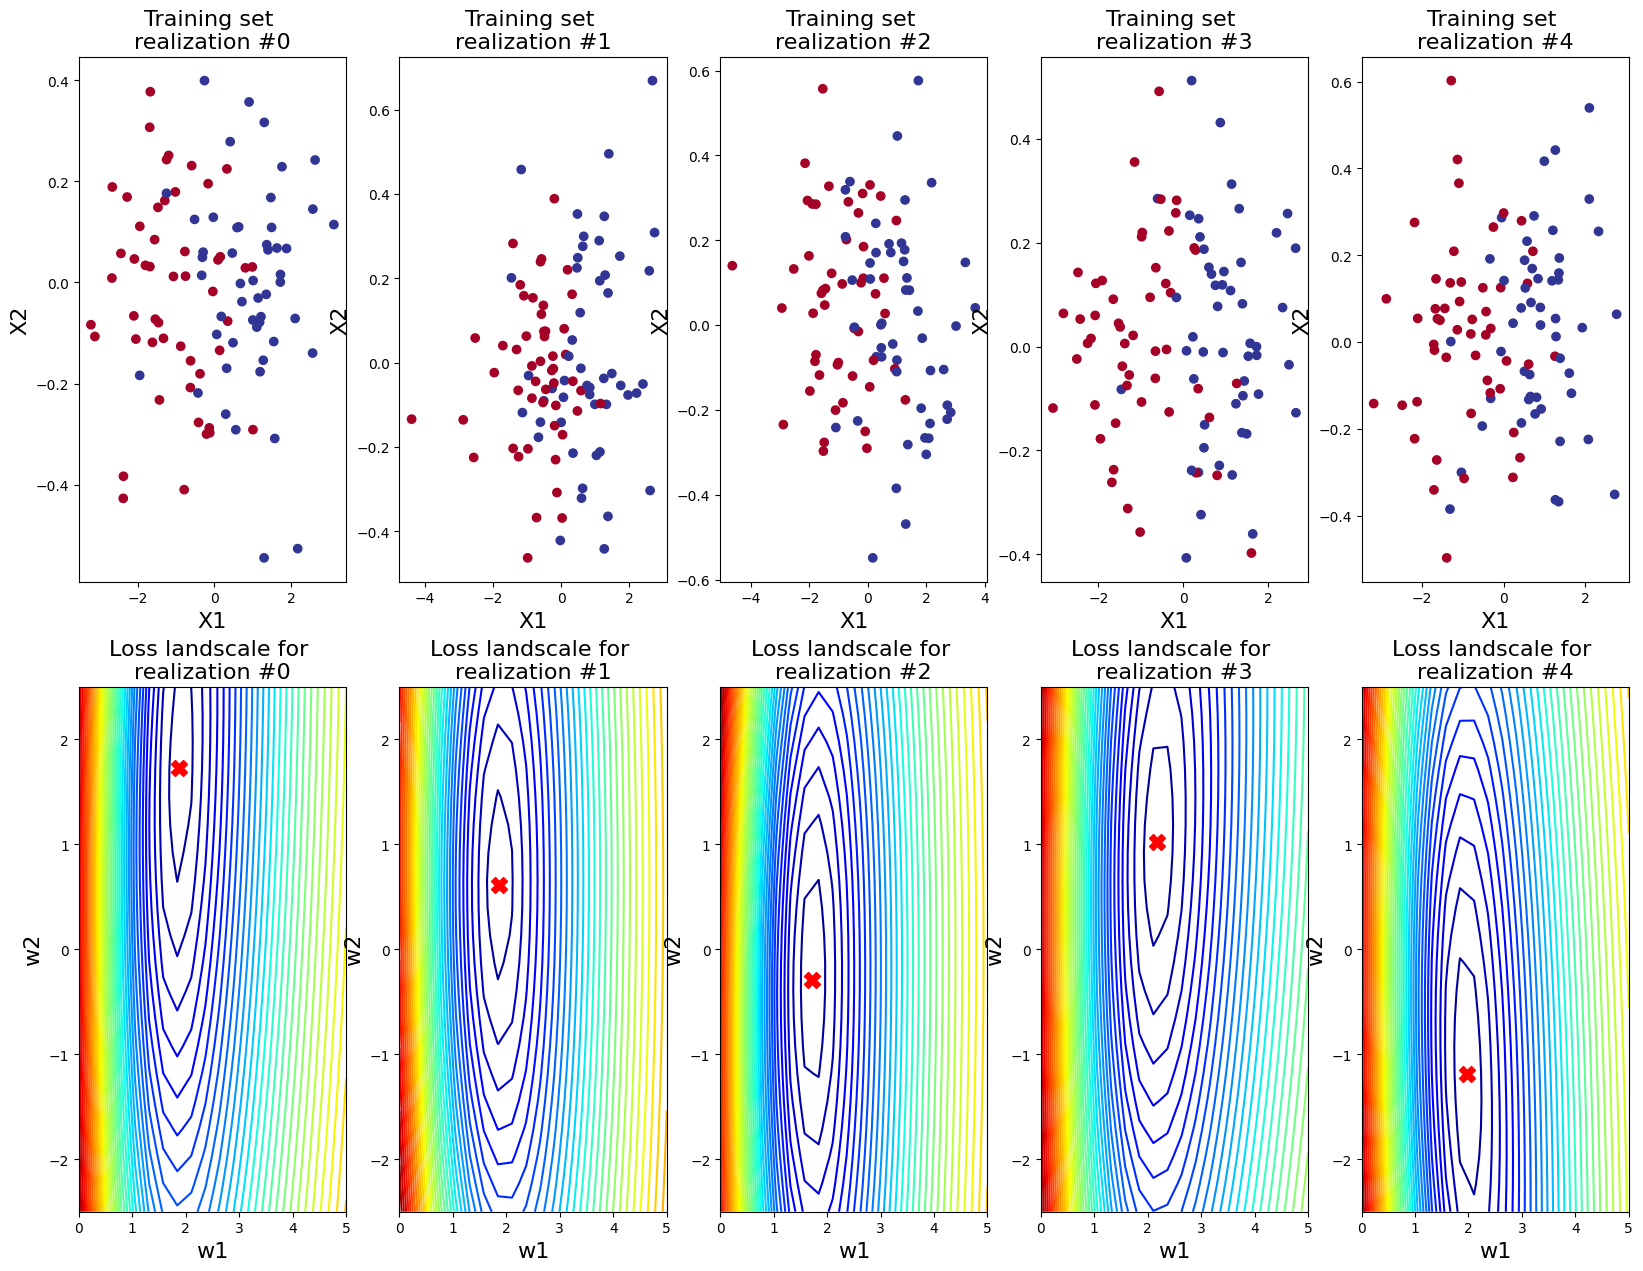

In [23]:
from sklearn.linear_model import LogisticRegression

# Some technicalities to compute loss at all points of some grid
w1range = np.linspace(0, 5, 20)
w2range = np.linspace(-2.5, 2.5, 20)
W1mg, W2mg = np.meshgrid(w1range, w2range)

# !! try changing this !!
regularization = False

plt.figure(figsize=(20, 15)) #(8, 6))
fs = 16

for jj in range(5):
    
    # !! Regenerating the training set
    X_blob, y_blob = make_blobs(n_samples=N, n_features=2, centers=[[-1, 0], [1, 0]], cluster_std=1)
    X_blob[:,1] /= 5  # make sure the 2nd feature is just noise.

    plt.subplot(2,5,1+jj)
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);
    plt.xlabel('X1', fontsize=fs); plt.ylabel('X2', fontsize=fs)
    plt.title(f'Training set \nrealization #{jj}', fontsize=fs)

    lreg = 0.01 if regularization else 0.0    
    def f(w0, w1):
        return get_loss([w0, w1], X_blob, y_blob) + lreg * (w0**2+w1**2)
    
    # Some technicalities to compute loss at all points of some grid
    f_vectorized = np.vectorize(f)    
    Z = f_vectorized(W1mg, W2mg)
    Z = np.log(Z-np.min(Z)+0.1) # optional, just to shape the contours.
    plt.subplot(2,5,6+jj)
    plt.title(f'Loss landscale for \nrealization #{jj}', fontsize=fs)
    
    #contour = plt.contourf(W1mg, W2mg, Z, levels=20, cmap='pink') #plt.colorbar(contour)
    contour = plt.contour(W1mg, W2mg, Z, levels=40, cmap='jet')

    # The default is WITH regularization (check documentation)
    if regularization:
        lr = LogisticRegression(fit_intercept=False) # C=
    else:
        lr = LogisticRegression(fit_intercept=False, penalty=None) 
        
    lr.fit(X_blob, y_blob)
    plt.plot([lr.coef_[0,0]], [lr.coef_[0,1]], marker='X', color='r', markersize=12)
    plt.xlabel('w1', fontsize=fs); plt.ylabel('w2', fontsize=fs)
    plt.ylim(-2.5, 2.5)

In [14]:
# TODO draw real center (LR with a large dataset)
# TODO explain how the above demonstrates reducing variance, at expense of introducing bias.
# TODO draw the decision boundary, with uncertainty bands 
# TODO add polynomial features, for curved (+banded) boundary

array([[2.42241269, 0.60281249]])